In [1]:
import class_function as cf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../Data/result_6.csv')
X = data.drop(columns=['TARGET'])
Y = data.TARGET

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [3]:
class Multi_XGB(object):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        pass
    
    def train(self, x_train, y_train):
        data = pd.concat([x_train, y_train], axis=1)
        group_result = data.groupby(y_train.name)
        data_0 = group_result.get_group(0)
        data_1 = group_result.get_group(1)
        #0比1多
        im_dergee = int(data_0.shape[0]/data_1.shape[0])
        self.im_dergee = im_dergee
        data_list = []
        maj_number = data_0.shape[0]
        balanced_number = data_1.shape[0]
        for i in range(im_dergee):
            if i < im_dergee - 1:
                data_list.append(data_0.iloc[i*balanced_number:(i+1)*balanced_number, :])
            else:
                data_list.append(data_0.iloc[i*balanced_number:, :])
        
        #print(data_list[0])
                
        xgb_cla_list = []
        for i in range(im_dergee):
            x_y = pd.concat([data_list[i], data_1], axis=0)
            #print(x_y)
            x_train_ = x_y.iloc[:, :x_y.shape[1]-1]
            y_train_ = x_y.iloc[:, x_y.shape[1]-1]
            #print(y_train_)
            xgb_cla_list.append(xgb.XGBClassifier(**self.kwargs))
            xgb_cla_list[i].fit(x_train_, y_train_)
            print('*' * 40)
            print(xgb_cla_list[i].classes_)
        
        self.xgb_cla_list = xgb_cla_list
        
    def predict(self, x_test, threshold):
        xgb_cla_list = self.xgb_cla_list
        predict_proba_list = []
        for i in range(self.im_dergee):
            predict_proba = xgb_cla_list[i].predict_proba(x_test)
            predict_proba_1 = []
            for j in range(len(predict_proba)):
                predict_proba_1.append(predict_proba[j][1])
                
            predict_proba_list.append(predict_proba_1)
            
        predict_proba = []
        result = []
        for i in range(len(predict_proba_list[0])):
            tmp = 0
            for j in range(len(predict_proba_list)):
                tmp += predict_proba_list[j][i]
            
            proba = tmp / self.im_dergee
            predict_proba.append(proba)
            if proba > threshold:
                result.append(1)
            else:
                result.append(0)
        
        self.predict_proba = predict_proba
        self.result = result
        

In [14]:
multi_xgb = Multi_XGB(max_depth=10, n_estimators=200, random_state=0)
multi_xgb.train(x_train, y_train)

****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]


In [15]:
multi_xgb.predict(x_test, 0.6)
multi_xgb.result[:5]

[0, 0, 0, 0, 0]

In [16]:
multi_xgb.predict_proba

[0.15993401882323352,
 0.1913108236410401,
 0.5684369721195914,
 0.11589583686806938,
 0.254535129124468,
 0.2713614736091007,
 0.1309692287309603,
 0.4727191654118625,
 0.48507333072749054,
 0.10748084024949507,
 0.5027901990847155,
 0.12116979198022322,
 0.13142509013414383,
 0.16288147121667862,
 0.03751187132332812,
 0.3620644631710919,
 0.4275602969256314,
 0.565630083734339,
 0.308728273619305,
 0.377274595878341,
 0.37102856690233404,
 0.8608011874285612,
 0.5647710317915137,
 0.17607887021519922,
 0.4301855889233676,
 0.5875606726516377,
 0.12471194429831071,
 0.6957356658848849,
 0.6354162042791193,
 0.1655452928759835,
 0.891765215180137,
 0.7072968266227029,
 0.6748535795645281,
 0.8014586567878723,
 0.6420041972940619,
 0.24606850201433356,
 0.7224185412580316,
 0.5327239876443689,
 0.7911581071940336,
 0.6261873028495095,
 0.5413988828659058,
 0.5733964389020746,
 0.11966670202937993,
 0.5079011754556135,
 0.14538045837120575,
 0.1824348196387291,
 0.5624707828868519,
 0.2

In [17]:
fbc = cf.For_binary_classifier(multi_xgb.result, y_test)

                    Real +          Real -     
   Predict +         3853            16523     
   Predict -         3520            68358     

准确率： 0.782741127755978
召回率： 0.522582395225824
精准率： 0.18909501374165685

漏警率： 0.47741760477417605
虚警率： 0.8109049862583432
F1: 0.2777037010342715
fpr: 0.1946607603586197


In [18]:
threshold_list = np.arange(0, 1, 0.01)
accuracy_list = []
recall_list = []
precision_list = []
MissingAlarm_list = []
FalseAlarm_list = []
F1_list = []
fpr_list = []

y_proba = multi_xgb.predict_proba
for threshold in threshold_list:
    #y_predicted = multi_xgb.predict(x_test, threshold)
    y_predicted = []
    
    for proba in y_proba:
        if proba > threshold:
            y_predicted.append(1)
        else:
            y_predicted.append(0)
            
    fbc = cf.For_binary_classifier(y_predicted, y_test)
    accuracy_list.append(fbc.accuracy)
    recall_list.append(fbc.recall)
    precision_list.append(fbc.precision)
    MissingAlarm_list.append(fbc.MissingAlarm)
    FalseAlarm_list.append(fbc.FalseAlarm)
    F1_list.append(fbc.F1)
    fpr_list.append(fbc.fpr)
    print('*' * 40)
    

                    Real +          Real -     
   Predict +         7373            84881     
   Predict -           0               0       

准确率： 0.07992065384698767
召回率： 1.0
精准率： 0.07992065384698767

漏警率： 0.0
虚警率： 0.9200793461530123
F1: 0.14801208507733848
fpr: 1.0
****************************************
                    Real +          Real -     
   Predict +         7373            84871     
   Predict -           0              10       

准确率： 0.0800290502308843
召回率： 1.0
精准率： 0.07992931789601491

漏警率： 0.0
虚警率： 0.9200706821039851
F1: 0.14802694319242699
fpr: 0.9998821880043826
****************************************
                    Real +          Real -     
   Predict +         7373            84783     
   Predict -           0              98       

准确率： 0.08098293840917467
召回率： 1.0
精准率： 0.08000564260601589

漏警率： 0.0
虚警率： 0.9199943573939842
F1: 0.14815782334796895
fpr: 0.9988454424429496
****************************************
                    Real +         

                    Real +          Real -     
   Predict +         6816            59949     
   Predict -          557            24932     

准确率： 0.3441368395950311
召回率： 0.9244540892445409
精准率： 0.10208941810829027

漏警率： 0.07554591075545913
虚警率： 0.8979105818917097
F1: 0.18387331732714668
fpr: 0.7062711325267139
****************************************
                    Real +          Real -     
   Predict +         6759            58396     
   Predict -          614            26485     

准确率： 0.36035293862596746
召回率： 0.9167231791672318
精准率： 0.10373724196147648

漏警率： 0.08327682083276822
虚警率： 0.8962627580385235
F1: 0.1863831899404368
fpr: 0.6879749296073326
****************************************
                    Real +          Real -     
   Predict +         6700            56872     
   Predict -          673            28009     

准确率： 0.3762330088668242
召回率： 0.9087210090872101
精准率： 0.10539231108034984

漏警率： 0.0912789909127899
虚警率： 0.8946076889196501
F1: 0.1888787088589

                    Real +          Real -     
   Predict +         5128            29420     
   Predict -         2245            55461     

准确率： 0.656762850391311
召回率： 0.6955106469551064
精准率： 0.1484311682297094

漏警率： 0.30448935304489355
虚警率： 0.8515688317702906
F1: 0.24465065241764272
fpr: 0.34660289110637243
****************************************
                    Real +          Real -     
   Predict +         5036            28304     
   Predict -         2337            56577     

准确率： 0.6678626401023262
召回率： 0.6830326868303269
精准率： 0.1510497900419916

漏警率： 0.3169673131696731
虚警率： 0.8489502099580084
F1: 0.24739026846461815
fpr: 0.3334550723954713
****************************************
                    Real +          Real -     
   Predict +         4953            27177     
   Predict -         2420            57704     

准确率： 0.6791792225811347
召回率： 0.671775396717754
精准率： 0.15415499533146593

漏警率： 0.328224603282246
虚警率： 0.8458450046685341
F1: 0.2507657646254715
f

                    Real +          Real -     
   Predict +         2614            8146      
   Predict -         4759            76735     

准确率： 0.8601144665813949
召回率： 0.35453682354536825
精准率： 0.24293680297397768

漏警率： 0.6454631764546317
虚警率： 0.7570631970260223
F1: 0.28831412342138646
fpr: 0.09596965162992896
****************************************
                    Real +          Real -     
   Predict +         2500            7518      
   Predict -         4873            77363     

准确率： 0.8656860407136818
召回率： 0.33907500339075003
精准率： 0.2495508085446197

漏警率： 0.66092499660925
虚警率： 0.7504491914553804
F1: 0.2875050313380484
fpr: 0.08857105830515663
****************************************
                    Real +          Real -     
   Predict +         2350            6961      
   Predict -         5023            77920     

准确率： 0.8700977735382748
召回率： 0.31873050318730506
精准率： 0.2523896466544947

漏警率： 0.6812694968126949
虚警率： 0.7476103533455053
F1: 0.281707024694317

                    Real +          Real -     
   Predict +          134             123      
   Predict -         7239            84758     

准确率： 0.9201985821752986
召回率： 0.018174420181744203
精准率： 0.5214007782101168

漏警率： 0.9818255798182558
虚警率： 0.47859922178988323
F1: 0.035124508519003936
fpr: 0.0014490875460939432
****************************************
                    Real +          Real -     
   Predict +          92              63       
   Predict -         7281            84818     

准确率： 0.9203936956663126
召回率： 0.012477960124779601
精准率： 0.5935483870967742

漏警率： 0.9875220398752204
虚警率： 0.40645161290322585
F1: 0.024442082890541974
fpr: 0.0007422155723895807
****************************************
                    Real +          Real -     
   Predict +          48              27       
   Predict -         7325            84854     

准确率： 0.9203069785591953
召回率： 0.0065102400651024005
精准率： 0.64

漏警率： 0.9934897599348976
虚警率： 0.36
F1: 0.01288936627282492
fpr: 0.0003

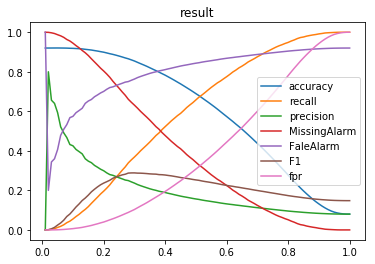

In [19]:
x_list = 1 - np.arange(0, 1, 0.01)
plt.title('result')
plt.plot(x_list, accuracy_list, label='accuracy')
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.plot(x_list, MissingAlarm_list, label='MissingAlarm')
plt.plot(x_list, FalseAlarm_list, label='FaleAlarm')
plt.plot(x_list, F1_list, label='F1')
plt.plot(x_list, fpr_list, label='fpr')
plt.legend()
plt.show()

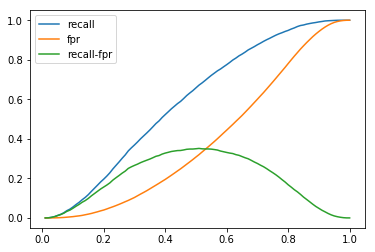

In [20]:
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, fpr_list, label='fpr')
plt.plot(x_list, [recall_list[i] - fpr_list[i] for i in range(len(recall_list))], label='recall-fpr')
plt.legend()
plt.show()

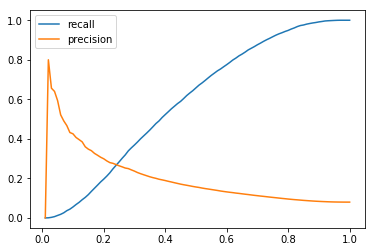

In [21]:
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.legend()
plt.show()

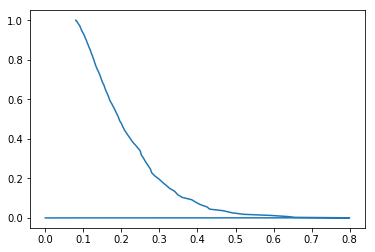

In [22]:
plt.plot(precision_list, recall_list, label='precision')
plt.show()

In [23]:
tpr_min_fpr = [recall_list[i] - fpr_list[i] for i in range(len(recall_list))]
ks = max(tpr_min_fpr)
ks

0.351597736228363